Te idea is to convert the Python pre- and post-processing steps to a TensorFlow model so it can be applied easily to any language supporting TensorFlow such as Java without rewriting all the processing steps. 

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tifffile
import tensorflow as tf
from skimage import color
from skimage import transform

root_dir = Path("/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/")
saved_model_dir = root_dir / "saved_model"

model_name = "microtubule_coco_512"

# Configurations of the model
BATCH_SIZE = 1

IMAGE_RESIZE_MODE = "square"
IMAGE_MIN_DIM = 10
IMAGE_MAX_DIM = 512
MIN_SCALE = 1
MEAN_PIXEL = [123.7, 116.8, 103.9]
CLASS_IDS = ["BG", "microtubule"]
IMAGE_SHAPE = [IMAGE_MAX_DIM, IMAGE_MAX_DIM, 3]

BACKBONE = "resnet50"
BACKBONE_STRIDES = [4, 8, 16, 32, 64]
RPN_ANCHOR_SCALES = [8, 16, 32, 64, 128]
RPN_ANCHOR_RATIOS = [0.5, 1, 2]
RPN_ANCHOR_STRIDE = 1

INPUT_NODE_IMAGE_NAME = "input_image"
INPUT_NODE_IMAGE_METADATA_NAME = "input_image_meta"
INPUT_NODE_ANCHORS_NAME = "input_anchors"
OUTPUT_NODE_NAMES = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask", "rois"]

tf_model_path = saved_model_dir / f"tf_model_{model_name}.pb"
assert tf_model_path.is_file()

preprocessing_model_path = saved_model_dir / "preprocessing_graph.pb"
postprocessing_model_path = saved_model_dir / "postprocessing_graph.pb"

def get_tensor(graph, name, suffix=":0"):
    return graph.get_tensor_by_name(f"{name}{suffix}")

# Load an image (for testing purpose)

In [212]:
image_dir = Path("/home/hadim/Documents/Code/Postdoc/ij/testdata/")
image_path = image_dir / "fake-flat-corrected.tif"
#image_path = image_dir / "Cell_Colony-1.tif"
#image_path = image_dir / "Untitled.tif"
#image_path = image_dir / "7,5uM_emccd_lapse1-small-8bit-Single.tif"
#image_path = image_dir / "test-tracking-single.tif"
#image_path = image_dir / "test-tracking.tif"
image_path = image_dir / "Spindle-1-Frame.tif"
#image_path = image_dir / "Spindle-1-Frame-Small.tif"

original_images = tifffile.imread(str(image_path))
if len(original_images.shape) == 2:
    original_images = np.expand_dims(original_images, 0)
original_images.shape

(1, 196, 171)

(196, 171)

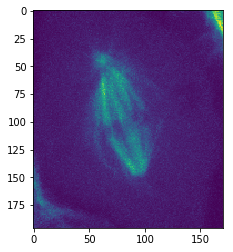

In [213]:
original_image = original_images[0]
input_image = original_image
plt.imshow(input_image)
input_image.shape

# Functions used to build the graphs

In [214]:
def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = tf.meshgrid(tf.cast(scales, tf.float32), ratios)
    scales = tf.layers.flatten(scales)
    ratios = tf.layers.flatten(ratios)

    # Enumerate heights and widths from scales and ratios
    heights = scales / tf.sqrt(ratios)
    widths = scales * tf.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = tf.cast(tf.range(0, shape[0], anchor_stride) * feature_stride, tf.float32)
    shifts_x = tf.cast(tf.range(0, shape[1], anchor_stride) * feature_stride, tf.float32)
    shifts_x, shifts_y = tf.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = tf.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = tf.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = tf.reshape(tf.stack([box_centers_y, box_centers_x], axis=2), [-1, 2])
    box_sizes = tf.reshape(tf.stack([box_heights, box_widths], axis=2), [-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = tf.concat([box_centers - 0.5 * box_sizes,
                       box_centers + 0.5 * box_sizes], axis=1)
    return boxes

def norm_boxes(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [N, (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.
    Returns:
        [N, (y1, x1, y2, x2)] in normalized coordinates
    """

    h = tf.cast(shape[0], dtype=tf.float32)
    w = tf.cast(shape[1], dtype=tf.float32)

    scale = tf.stack([h - 1, w - 1, h - 1, w - 1], axis=0)
    shift = tf.constant([0, 0, 1, 1], dtype=tf.float32)
    return tf.divide((boxes - shift), scale)

def denorm_boxes(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [N, (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.
    Returns:
        [N, (y1, x1, y2, x2)] in pixel coordinates
    """
    h = tf.cast(shape[0], dtype=tf.float32)
    w = tf.cast(shape[1], dtype=tf.float32)
    
    scale = tf.stack([h - 1, w - 1, h - 1, w - 1], axis=0)
    shift = tf.constant([0, 0, 1, 1], dtype=tf.float32)
    return tf.cast(tf.round(tf.multiply(boxes, scale) + shift), dtype=tf.int32)

def broadcastable_where(condition, x=None, y=None, *args, **kwargs):
    """Would be soon available natively:
    https://github.com/tensorflow/tensorflow/pull/15982"""
    if x is None and y is None:
        return tf.where(condition, x, y, *args, **kwargs)
    else:
        _shape = tf.broadcast_dynamic_shape(tf.shape(condition), tf.shape(x))
        _broadcaster = tf.ones(_shape)
        return tf.where(
            condition & (_broadcaster > 0.0), 
            x * _broadcaster,
            y * _broadcaster,
            *args, **kwargs
        )
    
def unmold_mask(mask, bbox, image_shape):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.
    Returns a binary mask with the same size as the original image.
    """
    threshold = 0.5
    
    output_h = tf.cast(image_shape[0], tf.int32)
    output_w = tf.cast(image_shape[1], tf.int32)
    output_c = tf.cast(image_shape[2], tf.int32)
    
    bbox = tf.cast(bbox, tf.int32)
    
    y1 = bbox[0]
    x1 = bbox[1]
    y2 = bbox[2]
    x2 = bbox[3]
    h = y2 - y1
    w = x2 - x1

    size = tf.stack([h, w])
    mask = tf.image.resize_images(mask, size)
    mask = broadcastable_where(mask >= threshold, 1, 0)

    # Put the mask in the right location.
    full_mask = tf.image.pad_to_bounding_box(mask, y1, x1, output_h, output_w)
    return full_mask

# Build preprocessing graph

In [215]:
tf.reset_default_graph()

# Define the inputs

# Input image padded to IMAGE_MAX_DIM, IMAGE_MAX_DIM
image = tf.placeholder(np.float32, shape=(None, None), name="input_image")

# Original image size
h = tf.placeholder(tf.int32, shape=(), name="original_image_height")
w = tf.placeholder(tf.int32, shape=(), name="original_image_width")

min_dim = tf.placeholder(tf.int32, shape=(), name="image_min_dimension")
max_dim = tf.placeholder(tf.int32, shape=(), name="image_max_dimension")
min_scale = tf.placeholder(tf.float32, shape=(), name="minimum_scale")

mean_pixels = tf.placeholder(tf.float32, shape=(3, ), name="mean_pixels")

class_ids = tf.placeholder(tf.int32, shape=(None, ), name="class_ids")

backbone_strides = tf.placeholder(tf.int32, shape=(None, ), name="backbone_strides")
rpn_anchor_scales = tf.placeholder(tf.int32, shape=(None, ), name="rpn_anchor_scales")
rpn_anchor_ratios = tf.placeholder(tf.float32, shape=(None, ), name="rpn_anchor_ratios")
rpn_anchor_stride = tf.placeholder(tf.int32, shape=(), name="rpn_anchor_stride")

# Define preprocessing operations

# Crop to original size
image = tf.expand_dims(image, axis=2)
image = tf.image.crop_to_bounding_box(image, 0, 0, h, w)

# Convert to RGB
image = tf.image.grayscale_to_rgb(image)

window = tf.convert_to_tensor([0, 0, h, w])
scale = tf.constant(1, tf.float32)
padding = tf.convert_to_tensor([(0, 0), (0, 0), (0, 0)])
crop = tf.convert_to_tensor([0, 0, 0, 0])

# Warning: only mode "square" is supported here.
scale = tf.cond(tf.equal(min_dim, -1),
                lambda: scale,
                lambda: tf.maximum(tf.constant(1, tf.float32), tf.cast(min_dim / tf.minimum(h, w), tf.float32)))

scale = tf.cond(min_scale != -1 and scale < min_scale,
                lambda: min_scale,
                lambda: scale)

image_max = tf.maximum(h, w)
scale = tf.cond(max_dim != -1 and tf.cast(tf.round(tf.cast(image_max, tf.float32) * scale), tf.int32) > max_dim,
                lambda: tf.cast(max_dim / image_max, tf.float32),
                lambda: scale)

# scale != 1 is not supported at the moment. We assume the image is smaller than IMAGE_MAX_DIM

# Mode == "square"
top_pad = (max_dim - h) // 2
bottom_pad = max_dim - h - top_pad
left_pad = (max_dim - w) // 2
right_pad = max_dim - w - left_pad
padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
image = tf.pad(image, padding, mode='constant', constant_values=0)
window = (top_pad, left_pad, h + top_pad, w + left_pad)
window = tf.identity(window, name="window")

# Mold image
molded_image = tf.subtract(image, mean_pixels, name="molded_image")

# Build image metadata array
# Ideally all the value should be 
image_id = tf.constant(0)
image_meta = tf.concat([tf.cast([image_id], tf.float32),
                         tf.cast([h, w, 3], tf.float32),
                         tf.cast(tf.shape(molded_image), tf.float32),
                         tf.cast(window, tf.float32),
                         [scale],
                         tf.cast(class_ids, tf.float32)], axis=0)
image_meta = tf.cast(image_meta, tf.float32)
image_meta = tf.identity(image_meta, name="image_metadata")

# Compute backbone shapes
backbone_shape_y = tf.map_fn(lambda stride: tf.cast(tf.round(tf.ceil(tf.shape(image)[0] / stride)), tf.int32),
                             backbone_strides)
backbone_shape_x = tf.map_fn(lambda stride: tf.cast(tf.round(tf.ceil(tf.shape(image)[1] / stride)), tf.int32),
                             backbone_strides)
backbone_shapes = tf.stack([backbone_shape_y, backbone_shape_x])
backbone_shapes = tf.transpose(backbone_shapes, name="backbone_shapes")

# Here is a complicated nested tf.while_loop. Look this thread for details :
# https://stackoverflow.com/questions/50087883/tf-while-loop-with-flexible-row-numbers-per-iteration for details.

def make_inner_loop_body(total_size, anchor):
    def _inner_loop_body(j, ta):
        return j + 1, ta.write(total_size + j, anchor[j])
    return _inner_loop_body

def loop_body(i, total_size, ta):
    scale = rpn_anchor_scales[i]
    ratios = rpn_anchor_ratios
    shape = backbone_shapes[i]
    feature_stride = backbone_strides[i]
    anchor_stride = rpn_anchor_stride
    
    anchor = generate_anchors(scale, ratios, shape, feature_stride, anchor_stride)
    anchor = tf.cast(anchor, tf.float32)
    n_rows = tf.shape(anchor)[0]
    
    _, ta = tf.while_loop(lambda j, ta: j < n_rows,
                          make_inner_loop_body(total_size, anchor),
                          (tf.zeros([], dtype=tf.int32), ta))
    
    return i+1, total_size + n_rows, ta

anchors_array = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
num_elems = tf.shape(rpn_anchor_scales)[0]

_, _, anchors= tf.while_loop(lambda i, total_size, ta: i < num_elems,
                             loop_body,
                             (tf.zeros([], dtype=tf.int32),
                              tf.zeros([], dtype=tf.int32),
                              anchors_array))

anchors = anchors.stack()
anchors = tf.reshape(anchors, shape=(-1, 4))

# Normalize coordinates
anchors = norm_boxes(anchors, tf.shape(image)[:2])

anchors = tf.identity(anchors, name="anchors")

In [216]:
# Save preprocessing graph
with tf.Session() as sess:
    with tf.gfile.GFile(str(preprocessing_model_path), 'wb') as f:
        f.write(sess.graph_def.SerializeToString())

# Do preprocessing

In [217]:
# Load preprocessing graph
with tf.gfile.FastGFile(str(preprocessing_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')

In [218]:
with tf.Session() as sess:
  
    # Declare inputs
    image = get_tensor(sess.graph, "input_image")
    h = get_tensor(sess.graph, "original_image_height")
    w = get_tensor(sess.graph, "original_image_width")
    min_dim = get_tensor(sess.graph, "image_min_dimension")
    max_dim = get_tensor(sess.graph, "image_max_dimension")
    min_scale = get_tensor(sess.graph, "minimum_scale")
    mean_pixels = get_tensor(sess.graph, "mean_pixels")
    class_ids = get_tensor(sess.graph, "class_ids")
    backbone_strides = get_tensor(sess.graph, "backbone_strides")
    rpn_anchor_scales = get_tensor(sess.graph, "rpn_anchor_scales")
    rpn_anchor_ratios = get_tensor(sess.graph, "rpn_anchor_ratios")
    rpn_anchor_stride = get_tensor(sess.graph, "rpn_anchor_stride")
    
    feed_dict = {image: input_image,
                 h: original_image.shape[0],
                 w: original_image.shape[1],
                 min_dim: IMAGE_MIN_DIM,
                 max_dim: IMAGE_MAX_DIM,
                 min_scale: MIN_SCALE,
                 mean_pixels: MEAN_PIXEL,
                 class_ids: np.zeros([len(CLASS_IDS)], dtype=np.int32),
                 backbone_strides: BACKBONE_STRIDES,
                 rpn_anchor_scales: RPN_ANCHOR_SCALES,
                 rpn_anchor_ratios: RPN_ANCHOR_RATIOS,
                 rpn_anchor_stride: RPN_ANCHOR_STRIDE}
    
    # Declare outputs   
    fetches = {"molded_image": get_tensor(sess.graph, "molded_image"),
               "image_metadata": get_tensor(sess.graph, "image_metadata"),
               "window": get_tensor(sess.graph, "window"),
               "anchors": get_tensor(sess.graph, "anchors")}
    
    preprocessing_results = sess.run(fetches, feed_dict=feed_dict)
    
preprocessing_results.keys()

dict_keys(['molded_image', 'image_metadata', 'window', 'anchors'])

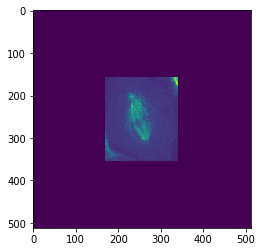

In [219]:
plt.imshow(preprocessing_results["molded_image"][:, :, 0])

# Predict with Mask RCNN

In [220]:
# Load Mask-RCNN model
with tf.gfile.FastGFile(str(tf_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')
    
# Prepare inputs
molded_images = [preprocessing_results["molded_image"]]
image_metas = [preprocessing_results["image_metadata"]]
anchors = [preprocessing_results["anchors"]]

with tf.Session() as sess:
    
    # Prepare inputs and outputs
    input_image_tensor = get_tensor(sess.graph, INPUT_NODE_IMAGE_NAME)
    input_image_metadat_tensor = get_tensor(sess.graph, INPUT_NODE_IMAGE_METADATA_NAME)
    input_anchor_tensor = get_tensor(sess.graph, INPUT_NODE_ANCHORS_NAME)
    
    input_data = {input_image_tensor: molded_images,
                  input_image_metadat_tensor: image_metas,
                  input_anchor_tensor: anchors}

    output_data = {node_name: get_tensor(sess.graph, f'output_{node_name}')
                   for node_name in OUTPUT_NODE_NAMES}
    
    # Run the prediction
    raw_results = sess.run(fetches=output_data, feed_dict=input_data)

raw_results.keys()

dict_keys(['detections', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'rois'])

In [221]:
raw_results['rois'].shape

(1, 2000, 4)

# Postprocessing 

In [222]:
tf.reset_default_graph()

# Define the inputs

# [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
detections = tf.placeholder(tf.float32, shape=(None, None, 6), name="detections")

# [N, height, width, num_classes]
mrcnn_mask = tf.placeholder(tf.float32, shape=(None, None, None, None, None), name="mrcnn_mask")

# [H, W, C] Original image shape before resizing
original_image_shape = tf.placeholder(tf.int64, shape=(3,), name="original_image_shape")

# [H, W, C] Shape of the image after resizing and padding
image_shape = tf.placeholder(tf.int64, shape=(3,), name="image_shape")

# [y1, x1, y2, x2] Pixel coordinates of box in the image where the real image is excluding the padding.
window = tf.placeholder(tf.int32, shape=(4), name="window")
window = tf.cast(window, tf.float32)

# Only select the first image of detections and mrcnn_mask
detections = detections[0]
mrcnn_mask = mrcnn_mask[0]

# Unmold detections

# How many detections do we have?
# Detections array is padded with zeros. Find the first class_id == 0.
zero_ix = tf.where(tf.equal(detections[:, 4], 0))[0]
N = tf.cond(tf.shape(zero_ix)[0] > 0, lambda: tf.cast(zero_ix[0], tf.int32), lambda: tf.cast(tf.shape(detections)[0], tf.int32))

# Extract boxes, class_ids, scores, and class-specific masks
boxes = detections[:N, :4]
class_ids = tf.cast(detections[:N, 4], tf.int32)
scores = detections[:N, 5]
masks = mrcnn_mask[:N, :, :, :]

# Translate normalized coordinates in the resized image to pixel
# coordinates in the original image before resizing
window = norm_boxes(window, image_shape[:2])
wy1 = window[0]
wx1 = window[1]
wy2 = window[2]
wx2 = window[3]
shift = tf.stack([wy1, wx1, wy1, wx1], axis=0)
wh = wy2 - wy1  # window height
ww = wx2 - wx1  # window width
scale = tf.stack([wh, ww, wh, ww], axis=0) 
# Convert boxes to normalized coordinates on the window
boxes = tf.divide(boxes - shift, scale)
# Convert boxes to pixel coordinates on the original image
boxes = denorm_boxes(boxes, original_image_shape[:2])

# Here we only keep the object with a non zero bounding box area.
include_ix = tf.where((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) > 0)[:, 0]
boxes = tf.cond(tf.shape(include_ix)[0] > 0, lambda: tf.gather(boxes, include_ix, axis=0), lambda: boxes)
class_ids = tf.cond(tf.shape(include_ix)[0] > 0, lambda: tf.gather(class_ids, include_ix, axis=0), lambda: class_ids)
scores = tf.cond(tf.shape(include_ix)[0] > 0, lambda: tf.gather(scores, include_ix, axis=0), lambda: scores)
masks = tf.cond(tf.shape(include_ix)[0] > 0, lambda: tf.gather(masks, include_ix, axis=0), lambda: masks)

# Resize masks to original image size and set boundary threshold.
def loop_body(i, ta):
    full_mask = unmold_mask(masks[i], boxes[i], original_image_shape)
    ta = ta.write(i, full_mask)
    return i+1, ta

num_elems = tf.shape(masks)[0]
tensor_array = tf.TensorArray(tf.float32, size=0, dynamic_size=True)

def resize_masks():
    num_elems = tf.shape(masks)[0]
    tensor_array = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    
    _, full_masks = tf.while_loop(lambda i, ta: i < num_elems, loop_body, [0, tensor_array])
    full_masks = full_masks.stack()
    
    # Project masks along the last axis without the background channel.
    # Could be problematic when more than one label exists.
    full_masks = tf.reduce_max(full_masks[:, :, :, 1:], axis=-1)
    
    return full_masks

full_masks = tf.cond(tf.equal(N, 0),
                        lambda: tf.zeros(0, tf.float32),
                        resize_masks)

# Remove all the objects with a zero area masks.
nonzero_masks = tf.cond(tf.shape(full_masks)[0] > 0, lambda: tf.reduce_max(full_masks, axis=(1, 2), keepdims=False,), lambda: tf.zeros(shape=(0,), dtype=tf.float32))
include_ix = tf.cond(tf.shape(nonzero_masks)[0] > 0, lambda: tf.where(nonzero_masks > 0)[:, 0], lambda: tf.zeros(shape=(0,), dtype=tf.int64))
boxes = tf.cond(tf.shape(include_ix)[0] > 0, lambda: tf.gather(boxes, include_ix, axis=0), lambda: boxes)
class_ids = tf.cond(tf.shape(include_ix)[0] > 0, lambda: tf.gather(class_ids, include_ix, axis=0), lambda: class_ids)
scores = tf.cond(tf.shape(include_ix)[0] > 0, lambda: tf.gather(scores, include_ix, axis=0), lambda: scores)
full_masks = tf.cond(tf.shape(include_ix)[0] > 0, lambda: tf.gather(full_masks, include_ix, axis=0), lambda: full_masks)

# Name the output tensors.
boxes = tf.identity(boxes, name="rois")
class_ids = tf.identity(class_ids, name="class_ids")
scores = tf.identity(scores, name="scores")
full_masks = tf.identity(full_masks, name="masks")

In [223]:
# Save preprocessing graph
with tf.Session() as sess:
    with tf.gfile.GFile(str(postprocessing_model_path), 'wb') as f:
        f.write(sess.graph_def.SerializeToString())

# Do postprocessing

In [224]:
# Load preprocessing graph
with tf.gfile.FastGFile(str(postprocessing_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.reset_default_graph()
    tf.import_graph_def(graph_def, name='')

In [225]:
with tf.Session() as sess:
  
    # Declare inputs
    detections = get_tensor(sess.graph, "detections")
    mrcnn_mask = get_tensor(sess.graph, "mrcnn_mask")
    original_image_shape = get_tensor(sess.graph, "original_image_shape")
    image_shape = get_tensor(sess.graph, "image_shape")
    window = get_tensor(sess.graph, "window")
    
    feed_dict = {detections: raw_results["detections"],
                 mrcnn_mask: raw_results["mrcnn_mask"],
                 original_image_shape: list(original_images.shape[1:3]) + [1],
                 image_shape: IMAGE_SHAPE,
                 window: preprocessing_results["window"]}
    
    # Declare outputs   
    fetches = {"rois": get_tensor(sess.graph, "rois"),
               "class_ids": get_tensor(sess.graph, "class_ids"),
               "scores": get_tensor(sess.graph, "scores"),
               "masks": get_tensor(sess.graph, "masks")}
    #fetches = {"test": get_tensor(sess.graph, "test/Merge")}
    
    postprocessing_results = sess.run(fetches, feed_dict=feed_dict)
    
postprocessing_results.keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

In [226]:
postprocessing_results['masks'].shape

(2, 196, 171)

# Display result of detection

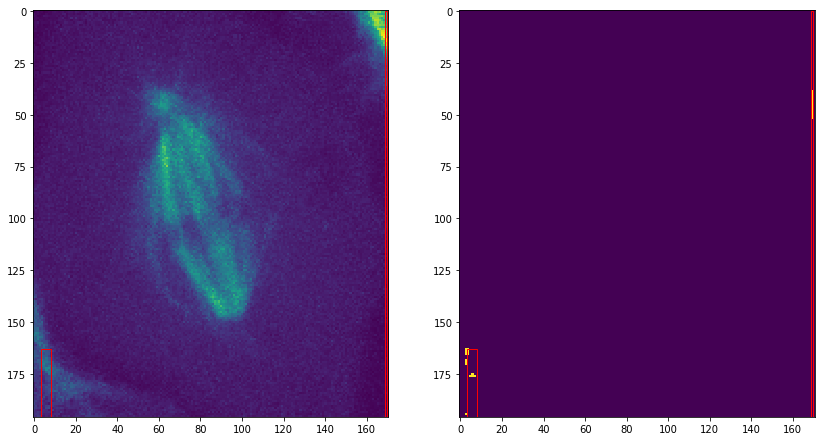

In [227]:
from matplotlib.patches import Rectangle

projected_masks = postprocessing_results['masks'].max(axis=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))

ax1.imshow(original_image)
ax2.imshow(projected_masks)

for i, roi in enumerate(postprocessing_results["rois"]):
    y1, x1, y2, x2 = roi
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
    ax1.add_artist(rect)
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
    ax2.add_artist(rect)

In [228]:
postprocessing_results['rois']

array([[  0, 169, 196, 170],
       [163,   3, 196,   8]], dtype=int32)